## ¿Qué son las GAN?

Las GAN, introducidas por Ian Goodfellow en 2014, son un tipo de modelo generativo que consta de dos redes neuronales: un generador y un discriminador. La red generadora toma un vector de ruido aleatorio como entrada y produce un punto de datos sintético, mientras que la red discriminadora evalúa el punto de datos generado e indica al generador si es realista o no.

![GAN](https://imgs.search.brave.com/qiJvz1a9sbExXtVcnmI31ugACNFAsOlA69uFhSOZPmE/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9jZG4u/Y2xpY2t3b3JrZXIu/Y29tL3dwLWNvbnRl/bnQvdXBsb2Fkcy8y/MDIyLzExL0dlbmVy/YXRpdmUtQWR2ZXJz/YXJpYWwtTmV0d29y/a3MtQXJjaGl0ZWN0/dXJlLXNjYWxlZC5q/cGc)

El objetivo del generador es producir puntos de datos indistinguibles de los datos reales, mientras que el objetivo del discriminador es identificar correctamente los puntos de datos generados. El proceso de entrenamiento de las GAN implica un juego de dos jugadores: el generador y el discriminador. El generador intenta producir puntos de datos realistas, mientras que el discriminador intenta clasificarlos correctamente como reales o falsos. Este proceso antagónico permite que ambas redes mejoren su rendimiento, generando datos altamente realistas. Esta tecnología es la base del aprendizaje profundo, una subcategoría del aprendizaje automático (ML) capaz de reconocer patrones complejos en diversos tipos de datos, como imágenes, sonidos y texto.

Tenéis una guía del equipo de TensorFlow aquí: https://www.tensorflow.org/tutorials/generative/dcgan?hl=es-419

In [41]:
# !pip install tensorflow keras matplotlib

In [11]:
import tensorflow as tf
from tensorflow import keras

tf.keras.backend.clear_session()

print (tf.__version__)

2.20.0


In [12]:
import numpy as np

# Descargamos los datos de entrenamiento
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalizamos los pixels y re-escalamos
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Creamos lotes reordenados para evitar sobreajustes en el entrenamiento
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### El Generador

El generador es la estructura que dado un _ruido_ aleatorio es capaz de generar una imagen. Las primeras imágenes no tendrán forma definida pero según lo enfrentemos al discriminador veremos cómo irán centrándose en imágenes que el discriminador tenga más difícil distinguir de las reales.

In [13]:
from keras import layers

noise_dim = 100

def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))

    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))

    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

generator = build_generator()
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

shape of the generated batch: (1, 28, 28, 1)


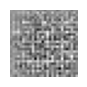

In [14]:
from utils import plot_results

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

# visualize sample output
plot_results(generated_image, n_cols=4)

print(f'shape of the generated batch: {generated_image.shape}')

### Discriminador

El discriminador es el encargado de intentar identificar qué imagen es falsa.

In [16]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-4.6208734e-06]], shape=(1, 1), dtype=float32)


Vemos que para esta imagen determina un valor cercano a cero. Ambas redes están sin entrenar así que deberemos esperar al entrenamiento completo para ver qué resulta.

In [18]:
# Función de perdida
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Optimización
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Pérdida (loss) del discriminador
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Y del generador
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
EPOCHS = 100

# La anotación @tf.function compila el proceso "model.compile()".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
import time

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    print ('Tiempo de ejecución en época {} es {} seg'.format(epoch + 1, time.time()-start))

**NOTA**: Tomará su tiempo... (60 min a 2 horas) si usáis 100 épocas.

In [22]:
train(train_dataset, 10) # EPOCHS

Tiempo de ejecución en época 1 es 4.806236982345581 seg
Tiempo de ejecución en época 2 es 4.766690015792847 seg
Tiempo de ejecución en época 3 es 4.780904769897461 seg
Tiempo de ejecución en época 4 es 4.768765449523926 seg
Tiempo de ejecución en época 5 es 4.775369644165039 seg


2025-10-13 14:44:18.540265: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Tiempo de ejecución en época 6 es 4.736577033996582 seg
Tiempo de ejecución en época 7 es 4.785806894302368 seg
Tiempo de ejecución en época 8 es 4.783245801925659 seg
Tiempo de ejecución en época 9 es 4.75222373008728 seg
Tiempo de ejecución en época 10 es 4.764974594116211 seg


Una vez entrenado es bueno salvar el modelo para poder reutilizarlo con

```py
from keras.models import load_model

generator = load_model("modelos/gan_gen.keras")
```

In [26]:
from keras.models import load_model

generator = load_model("modelos/gan_gen.keras")

shape of the generated batch: (1, 28, 28, 1)


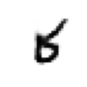

In [27]:
from utils import plot_results

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# visualize sample output
plot_results(generated_image, n_cols=4)

print(f'shape of the generated batch: {generated_image.shape}')

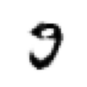

In [28]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# visualize sample output
plot_results(generated_image, n_cols=4)

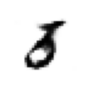

In [29]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# visualize sample output
plot_results(generated_image, n_cols=4)

In [40]:
generator.save("modelos/gan_gen.keras")

## Las GANs condicionales

Nos surge la duda ¿cómo puedo hacer que genere imágenes de un número concreto? Esto requiere que seamos capaces de condicionar la entrada. Es decir, incluir información sobre la categoría concreta sobre la que queremos generar el contenido. Esencialmente, debemos incluir esta información en la entrada del generador para que este sepa qué tipo de imagen o muestra queremos generar. Veremos que esto es un paso clave si queremos hacer que nuestras redes generen información de un tipo u otro.

https://keras.io/examples/generative/conditional_gan/

In [30]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [31]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

# Indicamos la clase concreta con la que estamos trabajando
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes

print(generator_in_channels, discriminator_in_channels)

138 11


In [32]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [29]:
from cgan import ConditionalGAN

cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

In [ ]:
cond_gan.fit(dataset, epochs=10) #EPOCHS

Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 112s 407ms/step - d_loss: 0.6726 - g_loss: 0.8400
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 111s 405ms/step - d_loss: 0.6792 - g_loss: 0.8326
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 107s 392ms/step - d_loss: 0.6812 - g_loss: 0.7888
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 108s 395ms/step - d_loss: 0.6971 - g_loss: 0.8046
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 108s 394ms/step - d_loss: 0.6934 - g_loss: 0.7816
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 107s 392ms/step - d_loss: 0.6919 - g_loss: 0.7838
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 107s 392ms/step - d_loss: 0.6908 - g_loss: 0.7516
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 108s 392ms/step - d_loss: 0.6799 - g_loss: 0.7963
Epoch 9/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 107s 392ms/step - d_loss: 0.6955 - g_loss: 0.7677
Epoch 10/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 107s 392ms/step - d_loss: 0.6868 - g_loss: 0.7575
Epoch 11/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 107s 391ms/step - d_loss: 0.6927 - g_loss: 0.74

In [ ]:
# Extraemos el generador
trained_gen = cond_gan.generator

Una vez entrenado es bueno salvar el modelo para poder reutilizarlo con

```py
from keras.models import load_model

generator = load_model("modelos/cgan_gen.keras")
```

In [36]:
from keras.models import load_model

trained_gen = load_model("modelos/cgan_gen.keras")

In [37]:
from keras import ops

# Seleccionamos el número de imágenes a generar (haciendo un morph entre ellas)
num_interpolation = 10  # @param {type:"integer"}

# Interpolamos el ruido
interpolation_noise = keras.random.normal(shape=(1, latent_dim))
interpolation_noise = ops.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = ops.reshape(interpolation_noise, (num_interpolation, latent_dim))

def interpolate_class(first_number, second_number):
    # Convertimos las etiquetas a one-hot encoding
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = ops.cast(first_label, "float32")
    second_label = ops.cast(second_label, "float32")

    # Calculamos la interpolación entre etiquetas
    percent_second_label = ops.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = ops.cast(percent_second_label, "float32")
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combinamos el ruido con la etiqueta a generar
    noise_and_labels = ops.concatenate([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake

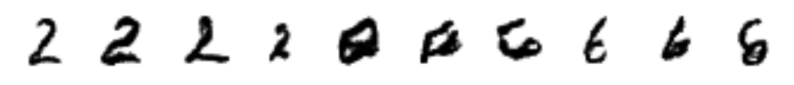

In [38]:
start_class = 2
end_class = 6

imagenes = interpolate_class(start_class, end_class)
imagenes *= 255.0
imagenes = imagenes.astype(np.uint8)
imagenes = ops.image.resize(imagenes, (96, 96)).numpy().astype(np.uint8)
plot_results(imagenes, n_cols=num_interpolation)

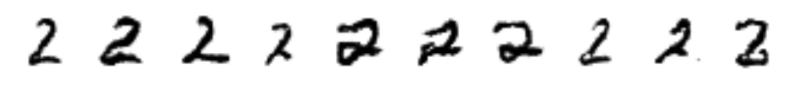

In [39]:
start_class = 2
end_class = 2

imagenes = interpolate_class(start_class, end_class)
imagenes *= 255.0
imagenes = imagenes.astype(np.uint8)
imagenes = ops.image.resize(imagenes, (96, 96)).numpy().astype(np.uint8)
plot_results(imagenes, n_cols=num_interpolation)

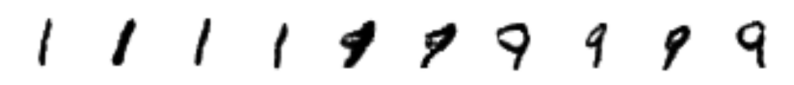

In [40]:
start_class = 1
end_class = 9

imagenes = interpolate_class(start_class, end_class)
imagenes *= 255.0
imagenes = imagenes.astype(np.uint8)
imagenes = ops.image.resize(imagenes, (96, 96)).numpy().astype(np.uint8)
plot_results(imagenes, n_cols=num_interpolation)

In [ ]:
trained_gen.save("modelos/cgan_gen.keras")

## ¿Qué son los AE?

Un Autoencoder (VAE) es una arquitectura básica con dos etapas, codificación y decodificación, pensada para poder obtener una representación densa en un espacio latente a modo de cuello de botella de la red.

![autoencoders](https://media.geeksforgeeks.org/wp-content/uploads/20231130152144/Autoencoder.png)

Tenéis una guía detallada en: https://www.tensorflow.org/tutorials/generative/autoencoder?hl=es-419

In [52]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [53]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [54]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0397 - val_loss: 0.0134
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0125 - val_loss: 0.0107
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0104 - val_loss: 0.0099
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0090 - val_loss: 0.0092
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0088 - val_loss: 0.0089


In [55]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

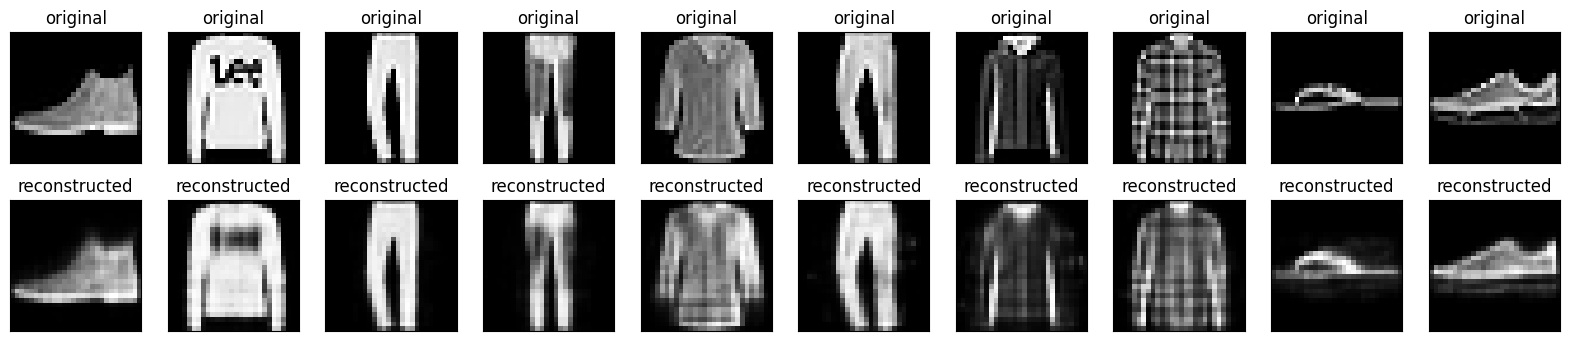

In [56]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Más en: https://www.tensorflow.org/tutorials/generative/autoencoder?hl=es-419